# Volatility Surface Generator

In [154]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from jax import grad

In [155]:
ticker_name = "SPY"
ticker = yf.Ticker(ticker_name)
ticker.options

sorted_calls = ticker.option_chain("2025-01-06").calls

for idx, call in sorted_calls.iterrows(): 
    print(call["bid"])

221.03
91.05
86.05
61.06
41.07
31.07
21.08
20.11
16.12
13.13
12.63
11.64
10.65
9.67
8.73
6.83
5.92
5.04
4.19
3.37
2.65
2.0
1.45
0.99
0.64
0.39
0.22
0.11
0.05
0.03
0.02
0.01
0.01
0.01
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [178]:
# BSM implementation

import numpy as np
from jax.scipy.stats import norm

In [ ]:
def blackScholes(S, K, T, r, sigma, q=0, is_call=True):
    d1 = (np.log(S/K) + (r - q + sigma **2 /2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if is_call:
        price = S * np.exp(-q * T) * norm.cdf(d1, 0, 1) - K * np.exp(-r * T ) * norm.cdf(d2, 0, 1)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S * np.exp(-q * T) * norm.cdf(-d1, 0, 1)
    
    return price

blackScholes(100, 90, 1, 0.05, 0.2, 0.01)

Array(12.926357, dtype=float32)

In [196]:
# Returns difference between actual and theoretical values
def loss(S, K, T, r, sigma_guess, price, q=0, is_call=True):
    theoretical_price = blackScholes(S, K, T, r, sigma_guess, q, is_call)
    return theoretical_price - price

loss_grad = grad(loss, argnums=4)
val = loss_grad(100, 90, 1, 0.05, 0.2, 500, 0.05)
val = loss_grad(100, 90, 1, 0.05, 0.2, 0.015, 30)
val

Array(0., dtype=float32, weak_type=True)

In [194]:
def solve_for_iv(S, K, T, r, q, market_price, epsilon=0.001, max_iter=20, is_call=True) -> np.float64:
    initial_sigma = 0.2
    
    for i in range(max_iter):
        bs_price = blackScholes(S, K, T, r, initial_sigma, q, is_call=is_call)
        vega_calc = loss_grad(S, K, T, r, initial_sigma, market_price, q, is_call)
        
        C = abs(bs_price - market_price)
        
        # if vega_calc == 0:
        #     return np.float64(0)
        
        # Newton's Method
        vol_new = initial_sigma - C/vega_calc
        
        if abs(bs_price - market_price) < epsilon:
            break
        
        initial_sigma = vol_new
    return vol_new
        

In [195]:
S, K, T, r, q, market_price = 100, 90, 1, 0.05, 0.015, 30
solve_for_iv(S, K, T, r, q, market_price, epsilon=0.01, max_iter=20, is_call=True)

Array(nan, dtype=float32)

In [146]:
total_calls = pd.DataFrame(columns=["symbol", "bid", "ask", "lastPrice", "strike", "expiration", "dte"])

iv_lst = []
moneyness_lst = []
dte_lst = []
S = ticker.fast_info["last_price"]

for datetime_string in ticker.options:
    sorted_calls = ticker.option_chain(datetime_string).calls
    datetime_object = datetime.strptime(datetime_string, '%Y-%m-%d')
    
    for idx, call in sorted_calls.iterrows(): 
        K = call["strike"]
        T = (datetime_object - datetime.now()).days / 365
        market_price = call["lastPrice"]
        iv = call["impliedVolatility"]
        #iv = solve_for_iv(S, K, T, r, market_price)
        
        iv_lst.append(iv)
        moneyness_lst.append(S/K)
        dte_lst.append(T)
        
        total_calls.loc[len(total_calls)] = [ticker_name, call["bid"], call["ask"], call["lastPrice"], call["strike"], datetime_string, (datetime_object - datetime.now()).days / 365]
    
total_calls

,symbol,bid,ask,lastPrice,strike,expiration,dte
0,SPY,221.03,222.27,216.76,370.0,2025-01-06,0.002740
1,SPY,91.05,92.28,90.71,500.0,2025-01-06,0.002740
2,SPY,86.05,87.28,88.42,505.0,2025-01-06,0.002740
3,SPY,61.06,62.29,55.75,530.0,2025-01-06,0.002740
4,SPY,41.07,42.30,42.06,550.0,2025-01-06,0.002740
...,...,...,...,...,...,...,...
3566,SPY,0.79,1.18,1.04,890.0,2027-01-15,2.027397
3567,SPY,0.73,1.11,1.00,895.0,2027-01-15,2.027397
3568,SPY,0.85,1.05,0.90,900.0,2027-01-15,2.027397
3569,SPY,0.83,0.88,0.88,905.0,2027-01-15,2.027397


In [147]:
iv_lst

[2.7304719238281248,
 1.111332568359375,
 1.0546922265625,
 0.778322529296875,
 0.5566450585937501,
 0.442388388671875,
 0.327155166015625,
 0.313483427734375,
 0.2683178637695312,
 0.23242955078125,
 1.0000000000000003e-05,
 1.0000000000000003e-05,
 1.0000000000000003e-05,
 1.0000000000000003e-05,
 1.0000000000000003e-05,
 0.07520456054687502,
 0.08789974609375001,
 0.08814388427734376,
 0.08765560791015625,
 0.08948664428710937,
 0.08838802246093751,
 0.08753353881835937,
 0.08545836425781252,
 0.08374939697265626,
 0.08350525878906252,
 0.08204042968750001,
 0.08130801513671876,
 0.08008732421875,
 0.07959904785156251,
 0.08399353515625002,
 0.0898528515625,
 0.092782509765625,
 0.10157148437499999,
 0.11036045898437499,
 0.11914943359374999,
 0.117196328125,
 0.12500875,
 0.132821171875,
 0.14063359375,
 0.148446015625,
 0.1562584375,
 0.16407085937500002,
 0.17188328125000002,
 0.179695703125,
 0.187508125,
 0.1914143359375,
 0.1992267578125,
 0.20703917968749996,
 0.2148516015625

Text(0.5, 0.92, 'Volatility Surface')

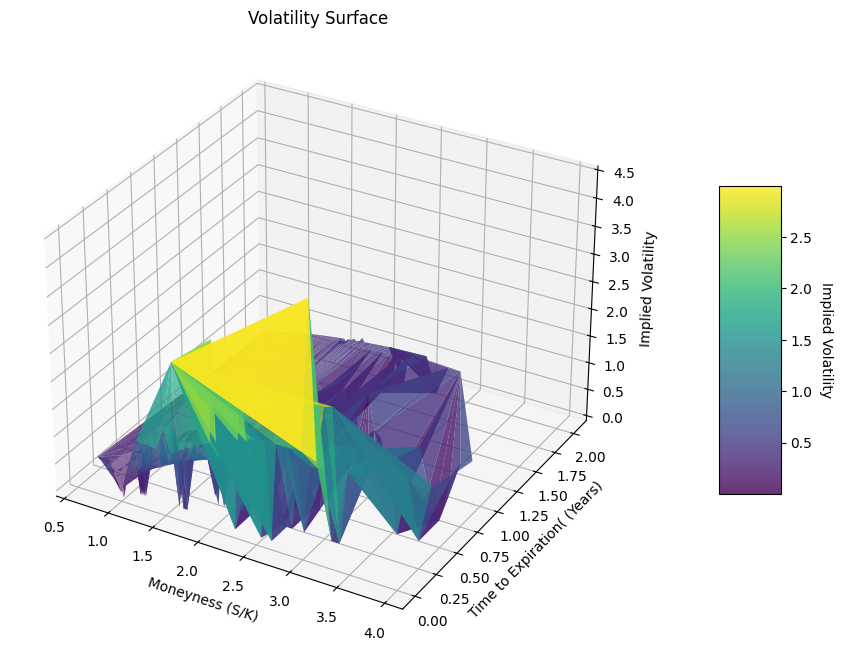

In [148]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_trisurf(moneyness_lst, dte_lst, iv_lst, 
                          cmap='viridis',
                          linewidth=0.1,
                          antialiased=True,
                          alpha=0.8)

colour_bar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, pad=0.1)
colour_bar.set_label("Implied Volatility", rotation=270, labelpad=15)

ax.set_xlabel("Moneyness (S/K)")
ax.set_ylabel("Time to Expiration( (Years)")
ax.set_zlabel("Implied Volatility")

plt.title("Volatility Surface")